In [2]:
!pip install geocoder

    100% |################################| 102kB 3.3MB/s a 0:00:01
    100% |################################| 829kB 1.0MB/s eta 0:00:01######          | 593kB 19.4MB/s eta 0:00:01
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /home/idies/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built future


In [3]:
print('Importing packages...')
import os
import pandas
import time
import numpy as np
from matplotlib import pyplot as plt
import geopandas
#import re
#from IPython.display import display, HTML
#from pprint import pprint
import geocoder
from shapely.geometry import Point

pandas.set_option('display.max_colwidth', -1)
debug = 2    # debug = 2 means also show maps

#basedir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/datasets/acs5/'
#census_data_basedir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/datasets/acs5/'

thisdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
datadir = thisdir + 'datasets_for_analysis/'
#census_data_dir = datadir + 'acs5/'
#census_acs5_rawdata_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/'

shapefile_basedir = '/home/idies/workspace/Storage/raddick/Baltimore/shapefiles/'
census_shapefile_tiger_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/'

#inflation_dir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/datasets/inflation/'

figdir = thisdir + 'figures/'
mapdir = thisdir + 'maps/'
#outdir = thisdir + 'datasets_for_analysis/'

for x in [datadir, figdir, mapdir]:
    if not(os.path.exists(x)):
        os.makedirs(x)

os.chdir(thisdir)
os.getcwd()
#os.listdir()

Importing packages...


'/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act'

# Read data to map

The file being read here is the output from script 5

In [4]:
df = pandas.read_csv(datadir+'reinvestment_by_census_tract_for_smallest_businesses.csv', encoding='utf-8', index_col=['census_tract', 'activity_year'])
#df = df.set_index(['census_tract', 'activity_year'])
print('backing up...')
df_bk = df
df.head(1)



backing up...


,,income_group_code,nLoans1,amtLoans1,nLoans100k,amtLoans100k,nLoans250k,amtLoans250k,nLoansToSmallest,amtLoansToSmallest,nLoansTotal,...,amtLoansTotal_adj,amtWorkingLoans_adj,mfi_adj,median_home_value_adj,amtLoans1_per_sbjob_adj,amtLoans100k_per_sbjob_adj,amtLoans250k_per_sbjob_adj,amtLoansToSmallest_per_sbjob_adj,amtLoansTotal_per_sbjob_adj,amtWorkingLoans_per_sbjob_adj
census_tract,activity_year,,,,,,,,,,,,,,,,,,,,,
101.0,2017,13,73,1047000,0,0,0,0,43,621000,73,...,1047000.0,1047000.0,104844.0,316500.0,2740.837696,0.0,0.0,1625.65445,2740.837696,2740.837696


## Read in one year's census tract shapefiles for later joining

In [5]:
thisyear = 2017

if (debug > 0):
    print('joining shapefiles for {0:.0f}...'.format(thisyear))
tract_shapes_gdf = geopandas.read_file(census_shapefile_tiger_basedir +'{0:.0f}/TRACT/tl_{0:.0f}_24_tract.shp'.format(thisyear))
tract_shapes_gdf = tract_shapes_gdf[tract_shapes_gdf['COUNTYFP'] == '510']
tract_shapes_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_shapes_gdf['NAME'], errors='coerce')
tract_shapes_gdf = tract_shapes_gdf.assign(census_tract = pandas.to_numeric(tract_shapes_gdf['GEOID'].apply(lambda x: x[5:9]+'.'+x[9:]), errors='coerce'))
print('ok')

joining shapefiles for 2017...
ok


## Read some other datasets useful for mapping

In [6]:
print('Reading city boundary...')
outline_filename = shapefile_basedir + 'baltimore_city_polygon/baltimore_city_polygon.shp'
city_outline_gdf = geopandas.read_file(outline_filename)
city_outline_gdf = city_outline_gdf.to_crs(tract_shapes_gdf.crs)

print('Reading water features...')
water_filename = shapefile_basedir + 'water/water.shp'
water_gdf = geopandas.read_file(water_filename)
water_gdf = water_gdf.set_index('OBJECTID')
water_gdf = water_gdf.to_crs(tract_shapes_gdf.crs)


#print('Finding location of JHU...')
#businesses = []
#biz1dict = {'name': 'Johns Hopkins University', 'address': '3400 N. Charles St. Baltimore, MD'}
##businesses.append(biz1dict)
##biz2dict = {'name': 'Refereshing Life Ministries', 'address': '2603 Baker St. Baltimore, MD'}
##businesses.append(biz2dict)
#g = geocoder.bing(biz1dict['address'], key='Agrc_VFxa6iK3mVYNIC1Mcao2TwVTPG5tDbok7UbDcCYf5PRGmnaeLF_Wm_znHeo')
#thegeometry = Point(g.latlng)
#g_df = pandas.DataFrame(data=g.latlng)
#g_df = g_df.T
#g_df = g_df.rename(columns={0: 'lat', 1: 'long'})
#g_df = g_df.assign(geometry=Point(g_df['long'], g_df['lat']))
#g_gdf = geopandas.GeoDataFrame(data=g_df, geometry='geometry')
#g_gdf.crs = {'init': 'epsg:4326'}
#g_gdf = g_gdf.to_crs(tract_shapes_gdf.crs)

print('Reading streets...')
s = time.time()
streets_filename = shapefile_basedir + 'streets/streetcl.shp'
streets_gdf = geopandas.read_file(streets_filename)
streets_gdf = streets_gdf.set_index('OBJECTID')
streets_gdf = streets_gdf.to_crs(tract_shapes_gdf.crs)
e = time.time()
print('Read {0:,.0f} street centerlines in {1:,.1f} seconds.'.format(len(streets_gdf), e-s))

print('Done!')
#g_gdf


Reading city boundary...
Reading water features...
Reading streets...
Read 48,160 street centerlines in 21.9 seconds.
Done!


getting from backup...


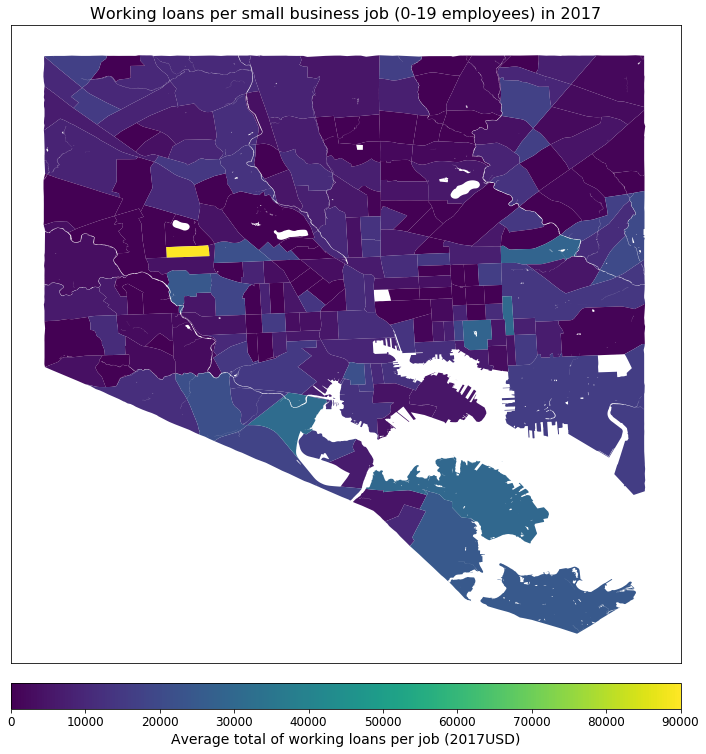

In [10]:
print('getting from backup...')
df = df_bk

scale = 0.25

fig, ax = plt.subplots(1,1, figsize=(48*scale,48*scale))

xdf = df.xs(thisyear, level=1).reset_index().merge(tract_shapes_gdf, how='left', on='census_tract').set_index('census_tract')

xdf = xdf[xdf['amtWorkingLoans_per_sbjob_adj'] != np.inf]

xgdf = geopandas.GeoDataFrame(xdf)
xgdf.crs = tract_shapes_gdf.crs    

xgdf.plot(column='amtWorkingLoans_per_sbjob_adj', ax=ax)
water_gdf.plot(ax=ax, color='white')

ax.set_aspect('equal')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax.set_title('Working loans per small business job (0-19 employees) in {:.0f}'.format(thisyear), fontsize=64*scale)

#for ix, thisrow in xgdf.iterrows():
#    if (thisrow['amtWorkingLoans_per_sbjob_adj'] > 0):
#        annotator = str(ix).replace('-', '- ')
#        annotator = annotator.replace('/', '/ ')
#        annotator = annotator.replace(' ', '\n')
#        annotator += '\n'
#        annotator += '${:,.0f}'.format(thisrow['amtWorkingLoans_per_sbjob_adj'])
#        annotator = annotator.upper()
#        ax.annotate(annotator, 
#                    xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                    xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                    ha='center', va='center', fontsize=24*scale, color='black', 
#                     backgroundcolor='white')

cax = fig.add_axes([0.125, 0.08, 0.775, 0.03])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=90000))
# fake up the array of the scalar mappable. Urgh...
sm._A = []

cbar = fig.colorbar(sm, cax=cax, format='%.0f', ticks=np.arange(0, 90001, 10000), orientation='horizontal')

cax.tick_params(labelsize=48*scale)

cbar.set_label('Average total of working loans per job (2017USD)', fontsize=56*scale)

#plt.savefig(mapdir+'2017_sb.svg', format='svg')
#print('done')
plt.show()


In [6]:
xdf['amtWorkingLoans_per_sbjob_adj'].max()

82333.33333333331

In [ ]:
df.columns